In [94]:
import pandas as pd
import numpy as np
import os


import torch
import torch.nn as nn
import os
import itertools
import json
import traceback

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from classification_rnn import ClassificationRNN, DEVICE



In [95]:
BASE = "../../data/aisdk/"

In [96]:
# df = pd.read_parquet("traj.parquet")
# df.loc[df["ClusterLabel"] == -1, "ClusterLabel"] = 3
# print(df["ClusterLabel"].value_counts())
# df.to_parquet("traj2") # doesnt work

In [97]:
# df = pd.read_parquet("traj.parquet")
# print(df["ClusterLabel"].value_counts())

# 1 - Create the windows

In [98]:
def make_past_future_windows_np(
    past_len=30,
    future_len=30,
    step=1,
    input_path="traj.parquet",
    output_path="data/aisdk/processed/windows/train_trajectories.npz"
):
    """
    Load standardized, sorted trajectory data from an npz file,
    create past/future sliding windows, and save everything as NumPy arrays
    in a single .npz file:

        - past:    (N, past_len, num_features)
        - future:  (N, future_len, num_features)
        - traj_id: (N,) - original trajectory ID for each window

    """
    print(f"Loading trajectories from {input_path} ...")
    df = pd.read_parquet(input_path)

    df = df.sort_values(["Trajectory", "Timestamp"])


    feature_cols = ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
    grouped = df.groupby(["Trajectory", "ClusterLabel"])

    num_traj = len(grouped)
    print(f"Total trajectory segments: {num_traj}\n")

    processed_segments = 0
    total_windows = 0

    print(f"  → Found {num_traj} trajectories")
    print(f"  → Features: {feature_cols}")

    total_len = past_len + future_len

    past_list = []
    future_list = []
    traj_list = []
    cluster_list = []
    processed_segments = 0

    for (traj, cid), g in grouped:
        
        processed_segments += 1
        T = g.shape[0]
        if T < total_len:
            continue  # too short for one window

        # number of windows for this trajectory (with stride `step`)
        num_windows = (T - total_len) // step + 1
        total_windows += num_windows
        
        # Change to numerical features
        feats = g[feature_cols].to_numpy(dtype=float)

        for w in range(num_windows):
            start = w * step
            mid   = start + past_len
            end   = mid + future_len

            past_window = feats[start:mid]   # (past_len, F)
            future_window = feats[mid:end]   # (future_len, F)

            past_list.append(past_window)
            future_list.append(future_window)
            traj_list.append(traj)
            cluster_list.append(cid)

        if (processed_segments + 1) % 500 == 0:
            print(f"  → Processed {processed_segments+1}/{num_traj} trajectories, {len(past_list)} windows so far")

    if not past_list:
        raise RuntimeError("No windows generated. "
                            "Check past_len, future_len, and trajectory lengths.")

    print("Stacking windows into numpy arrays...")
    past = np.stack(past_list)     # (N, past_len, F)
    future = np.stack(future_list) # (N, future_len, F)
    traj_id = np.array(traj_list)  # (N,)
    cluster = np.array(cluster_list)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    print(f"Saving windows to {output_path} ...")
    np.savez_compressed(
        output_path,
        past=past,
        future=future,
        cluster=cluster,
        traj_id=traj_id,
        feature_cols=feature_cols,
        past_len=past_len,
        future_len=future_len,
        step=step,
    )

    print("\nDONE!")
    print(f"  → Total windows: {past.shape[0]:,}")
    print(f"  → Shape - past: {past.shape}, future: {future.shape}")
    print(f"  → Output saved to: {output_path}")

    # Summary statistics
    unique_trajs = np.unique(traj_id)
    print(f"  → Windows span {len(unique_trajs)} unique trajectories")
    print(f"  → Avg windows per trajectory: {len(past_list) / len(unique_trajs):.1f}")

In [ ]:
make_past_future_windows_np(
    input_path=os.path.join(BASE, "clustered_train/aisdk_2025"),
    output_path=os.path.join(BASE, "windows/train_trajectories.npz"),
)

make_past_future_windows_np(
    input_path  = os.path.join(BASE, "clustered_val/aisdk_2025"),
    output_path = os.path.join(BASE, "windows/val_trajectories.npz"),
)



Loading trajectories from ../../data/aisdk/clustered_train/aisdk_2025 ...


/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_29235/4178367685.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["Trajectory", "ClusterLabel"])


Total trajectory segments: 2160

  → Found 2160 trajectories
  → Features: ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
  → Processed 500/2160 trajectories, 53031 windows so far
  → Processed 1000/2160 trajectories, 121939 windows so far
  → Processed 1500/2160 trajectories, 191051 windows so far
  → Processed 2000/2160 trajectories, 271364 windows so far
Stacking windows into numpy arrays...
  → Processed 2000/2160 trajectories, 271364 windows so far
Stacking windows into numpy arrays...
Saving windows to ../../data/aisdk/windows/train_trajectories.npz ...
Saving windows to ../../data/aisdk/windows/train_trajectories.npz ...

DONE!
  → Total windows: 288,693
  → Shape - past: (288693, 30, 5), future: (288693, 30, 5)
  → Output saved to: ../../data/aisdk/windows/train_trajectories.npz
  → Windows span 2160 unique trajectories
  → Avg windows per trajectory: 133.7
Loading trajectories from ../../data/aisdk/clustered_val/aisdk_2025 ...
Total trajectory segments: 463

  → Found 463 traj

/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_29235/4178367685.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["Trajectory", "ClusterLabel"])


Saving windows to ../../data/aisdk/windows/val_trajectories.npz ...

DONE!
  → Total windows: 49,478
  → Shape - past: (49478, 30, 5), future: (49478, 30, 5)
  → Output saved to: ../../data/aisdk/windows/val_trajectories.npz
  → Windows span 463 unique trajectories
  → Avg windows per trajectory: 106.9

DONE!
  → Total windows: 49,478
  → Shape - past: (49478, 30, 5), future: (49478, 30, 5)
  → Output saved to: ../../data/aisdk/windows/val_trajectories.npz
  → Windows span 463 unique trajectories
  → Avg windows per trajectory: 106.9


In [101]:
def make_past_future_windows_np_test(
    past_len=30,
    future_len=30,
    step=1,
    input_path="traj.parquet",
    output_path="data/aisdk/processed/windows/train_trajectories.npz"
):
    """
    Load standardized, sorted trajectory data from an npz file,
    create past/future sliding windows, and save everything as NumPy arrays
    in a single .npz file:

        - past:    (N, past_len, num_features)
        - future:  (N, future_len, num_features)
        - traj_id: (N,) - original trajectory ID for each window

    """
    print(f"Loading trajectories from {input_path} ...")
    df = pd.read_parquet(input_path)

    df = df.sort_values(["Trajectory", "Timestamp"])


    feature_cols = ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
    grouped = df.groupby(["Trajectory"])

    num_traj = len(grouped)
    print(f"Total trajectory segments: {num_traj}\n")

    processed_segments = 0
    total_windows = 0

    print(f"  → Found {num_traj} trajectories")
    print(f"  → Features: {feature_cols}")

    total_len = past_len + future_len

    past_list = []
    future_list = []
    traj_list = []
    # cluster_list = []
    processed_segments = 0

    for (traj), g in grouped:
        
        processed_segments += 1
        T = g.shape[0]
        if T < total_len:
            continue  # too short for one window

        # number of windows for this trajectory (with stride `step`)
        num_windows = (T - total_len) // step + 1
        total_windows += num_windows
        
        # Change to numerical features
        feats = g[feature_cols].to_numpy(dtype=float)

        for w in range(num_windows):
            start = w * step
            mid   = start + past_len
            end   = mid + future_len

            past_window = feats[start:mid]   # (past_len, F)
            future_window = feats[mid:end]   # (future_len, F)

            past_list.append(past_window)
            future_list.append(future_window)
            traj_list.append(traj)
            # cluster_list.append(cid)

        if (processed_segments + 1) % 500 == 0:
            print(f"  → Processed {processed_segments+1}/{num_traj} trajectories, {len(past_list)} windows so far")

    if not past_list:
        raise RuntimeError("No windows generated. "
                            "Check past_len, future_len, and trajectory lengths.")

    print("Stacking windows into numpy arrays...")
    past = np.stack(past_list)     # (N, past_len, F)
    future = np.stack(future_list) # (N, future_len, F)
    traj_id = np.array(traj_list)  # (N,)
    # cluster = np.array(cluster_list)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    print(f"Saving windows to {output_path} ...")
    np.savez_compressed(
        output_path,
        past=past,
        future=future,
        # cluster=cluster,
        traj_id=traj_id,
        feature_cols=feature_cols,
        past_len=past_len,
        future_len=future_len,
        step=step,
    )

    print("\nDONE!")
    print(f"  → Total windows: {past.shape[0]:,}")
    print(f"  → Shape - past: {past.shape}, future: {future.shape}")
    print(f"  → Output saved to: {output_path}")

    # Summary statistics
    unique_trajs = np.unique(traj_id)
    print(f"  → Windows span {len(unique_trajs)} unique trajectories")
    print(f"  → Avg windows per trajectory: {len(past_list) / len(unique_trajs):.1f}")

In [102]:
make_past_future_windows_np_test(
    input_path  = os.path.join(BASE, "test/aisdk_2025"),
    output_path = os.path.join(BASE, "windows/test_trajectories.npz")
)

Loading trajectories from ../../data/aisdk/test/aisdk_2025 ...
Total trajectory segments: 464

  → Found 464 trajectories
  → Features: ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']
Stacking windows into numpy arrays...
Saving windows to ../../data/aisdk/windows/test_trajectories.npz ...


/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_29235/4067870969.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["Trajectory"])



DONE!
  → Total windows: 55,274
  → Shape - past: (55274, 30, 5), future: (55274, 30, 5)
  → Output saved to: ../../data/aisdk/windows/test_trajectories.npz
  → Windows span 464 unique trajectories
  → Avg windows per trajectory: 119.1


# 1 - Fetch the data

In [47]:
train_traj = np.load(os.path.join(BASE, "windows/train_trajectories.npz"))
val_traj = np.load(os.path.join(BASE, "windows/val_trajectories.npz"))
# test_traj = np.load(os.path.join(BASE, "windows/test_trajectories.npz"))

X_train, X_val = train_traj["past"], val_traj["past"]
y_train, y_val = train_traj["cluster"], val_traj["cluster"]

# %% Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

# Create data loaders
print(f"\nTensor shapes:")
print(f"  X_train_t: {X_train_t.shape}")
print(f"  X_val_t:   {X_val_t.shape}")
print(f"  y_train_t: {y_train_t.shape}")
print(f"  y_val_t:   {y_val_t.shape}")

# %% Create data loaders
def make_loaders(batch_size):
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


Tensor shapes:
  X_train_t: torch.Size([288693, 30, 5])
  X_val_t:   torch.Size([49478, 30, 5])
  y_train_t: torch.Size([288693])
  y_val_t:   torch.Size([49478])


In [91]:
train_traj['cluster']

array([-1, -1, -1, ..., -1, -1, -1], shape=(288693,))

In [92]:
cluster_labels_veda = []
for i in train_traj['cluster']:
    if i not in(cluster_labels_veda):
        cluster_labels_veda.append(i)
cluster_labels_veda

[np.int64(-1),
 np.int64(1),
 np.int64(6),
 np.int64(3),
 np.int64(4),
 np.int64(2),
 np.int64(7),
 np.int64(5),
 np.int64(0),
 np.int64(8)]

# 2 - Train
## 2.1 - Define functions for one run

In [48]:
def _train_one_run(cfg, train_loader, val_loader):
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = ClassificationRNN(
        input_size=cfg["input_size"],
        hidden_size=cfg["hidden_size"],
        num_classes=cfg["num_classes"], 
    ).to(device)

    opt = torch.optim.Adam(
        model.parameters(), 
        lr=cfg["lr"], 
        weight_decay=cfg["weight_decay"]
    )

    crit = nn.CrossEntropyLoss()

    best_val_loss = float("inf")

    train_losses = []
    train_accs     = []
    val_losses   = []
    val_accs     = []

    # %% Training loop
    for epoch in range(cfg["epochs"]):
    
        # ------ Training phase ------
        model.train()
        train_loss_total = 0.0
        train_correct = 0
        train_samples = 0
        
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} [Train]"):
            xb = xb.to(device)  # (B, seq_len, num_features)
            yb = yb.to(device)  # (B,)

            opt.zero_grad()
            logits = model(xb)  # (B, num_classes)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            opt.step()

            train_loss_total += loss.item() #* xb.size(0)

            # Calculate accuracy
            preds = logits.argmax(dim=1)  # (B,)
            train_correct += (preds == yb).sum().item()
            train_samples += yb.size(0)

        train_loss = train_loss_total / len(train_loader)
        train_acc = train_correct / train_samples if train_samples > 0 else 0.0

        # ------ Validation ------
        model.eval()
        val_loss_total = 0.0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} [Val]"):
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = crit(logits, yb)
                val_loss_total += loss.item() #*xb.size(0)

                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

        val_loss = val_loss_total / len(val_loader)
        val_acc = val_correct / val_samples if val_samples > 0 else 0.0

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"  → New best validation loss: {best_val_loss:.4f}")
        
    return model, train_losses, val_losses, train_accs, val_accs


## 2.2 - Hyperparameter tuning

In [49]:
# Handle noise labels (-1) before creating loaders
# Choose ONE of the strategies by setting the flags below.
DROP_NOISE = False              # remove all samples with label -1
INCLUDE_NOISE_AS_CLASS = True # if True and DROP_NOISE=False, map -1 to an extra class index


def filter_and_remap(X, y, drop_noise=True, include_noise_as_class=False):
    """Filter or remap noise labels (-1).
    Parameters:
        X: np.ndarray (N, T, F)
        y: np.ndarray (N,)
        drop_noise: remove samples with label -1 entirely
        include_noise_as_class: keep noise and map -1 -> last class index
    Returns:
        X_new, y_new, label_map (orig->new), inverse_map (new->orig)
    """
    y = np.asarray(y)
    if drop_noise and include_noise_as_class:
        raise ValueError("Choose either drop_noise OR include_noise_as_class, not both.")

    if drop_noise:
        mask = y != -1
        X = X[mask]
        y = y[mask]

    unique_pos = sorted([lab for lab in np.unique(y) if lab >= 0])
    label_map = {lab: i for i, lab in enumerate(unique_pos)}

    if include_noise_as_class and (-1 in y):
        # assign noise to last index
        label_map[-1] = len(unique_pos)
        unique_pos.append(-1)

    # remap
    y_new = np.array([label_map[lab] for lab in y], dtype=np.int64)
    inverse_map = {v: k for k, v in label_map.items()}
    return X, y_new, label_map, inverse_map

# Apply filtering/remapping to train & val
X_train, y_train, label_map_train, inv_label_map_train = filter_and_remap(
    X_train, y_train, drop_noise=DROP_NOISE, include_noise_as_class=INCLUDE_NOISE_AS_CLASS
)
X_val, y_val, label_map_val, inv_label_map_val = filter_and_remap(
    X_val, y_val, drop_noise=DROP_NOISE, include_noise_as_class=INCLUDE_NOISE_AS_CLASS
)

print(f"Original train windows (including potential noise): {train_traj['past'].shape[0]}")
print(f"Filtered train windows: {X_train.shape[0]}")
print(f"Filtered val windows:   {X_val.shape[0]}")
print(f"Number of classes after processing: {len(label_map_train)}")
print(f"First 10 label mappings: {list(label_map_train.items())[:10]}")

# Rebuild tensors after filtering/remapping
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

# If you prefer to IGNORE noise samples instead of filtering, you could:
# crit = nn.CrossEntropyLoss(ignore_index=noise_class_index)  # and keep -1 mapped appropriately
# and skip them in accuracy calculations.


Original train windows (including potential noise): 288693
Filtered train windows: 288693
Filtered val windows:   49478
Number of classes after processing: 10
First 10 label mappings: [(np.int64(0), 0), (np.int64(1), 1), (np.int64(2), 2), (np.int64(3), 3), (np.int64(4), 4), (np.int64(5), 5), (np.int64(6), 6), (np.int64(7), 7), (np.int64(8), 8), (-1, 9)]


In [50]:
# Define key metrics
input_size = X_train.shape[-1]
n_classes = int(y_train.max() + 1)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def hyperparameter_search_classification(
    device=device,
    input_size=input_size,
    num_classes=n_classes,
    search_type='grid',
    save_dir='../../checkpoints/classifier'
):
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*70)
    print("HYPERPARAMETER TUNING FOR CLASSIFICATION RNN")
    print("="*70)
    
    # -------- 1) Define search space --------
    if search_type == 'grid':
        param_grid = {
            # Tune these:
            'hidden_size'   : [64, 128],
            'num_layers'    : [1, 2],
            'dropout'       : [0.0, 0.3],
            'lr'            : [3e-4, 1e-3],
            'weight_decay'  : [0.0, 1e-4],
            
            # Fixed:
            'batch_size'    : [256],
            'epochs'        : [20],
            #'patience'     : [5],
            #'min_delta'    : [1e-4],
            'grad_clip'     : [1.0],
        }

        # total combos: 2 * 2 * 2 * 3 = 24
        
    elif search_type == 'quick':
        # Smaller search – good for smoke-testing
        param_grid = {
            'hidden_size'   : [64, 128],
            'num_layers'    : [1],
            'dropout'       : [0.0, 0.3],
            'lr'            : [3e-4],
            'weight_decay'  : [0.0, 1e-4],

            
            'batch_size'    : [256],
            'epochs'        : [15],
            #'patience'     : [3],
            #'min_delta'    : [1e-4],
            'grad_clip'     : [1.0],
        }
        # total combos: 2 * 1 * 2 * 1 = 4
        
    else:
        raise ValueError(f"Unknown search_type: {search_type}")
    
    # Generate combinations
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]
    
    print(f"{search_type.capitalize()} Search: {len(param_combinations)} combinations")
    # super rough estimate: 5 min / combo like your friend
    print(f"Estimated time: {len(param_combinations) * 5} minutes")
    print("="*70)
    
    # -------- 2) Tracking --------
    results = []
    best_score = float('inf')   # here: best_val_loss
    best_params = None
    start_time = datetime.now()
    
    # -------- 3) Main search loop --------
    for idx, params in enumerate(param_combinations):
        print(f"\n{'='*70}")
        print(f"Trial {idx+1}/{len(param_combinations)}")
        elapsed_min = (datetime.now() - start_time).total_seconds() / 60
        print(f"Time elapsed: {elapsed_min:.1f} min")
        print(f"{'='*70}")
        
        print("Testing config:")
        print(f"  hidden_size   = {params['hidden_size']}")
        print(f"  num_layers    = {params['num_layers']}")
        print(f"  dropout       = {params['dropout']}")
        print(f"  lr            = {params['lr']}")
        print(f"  weight_decay  = {params['weight_decay']}")
        print(f"  batch_size    = {params['batch_size']}")
        print(f"  epochs        = {params['epochs']}")
        print()
        
        try:
            # ---- Build config dict for your existing _train_one_run ----
            cfg = {
                "device": device,
                "input_size": input_size,
                "num_classes": num_classes,
                
                # training hyperparams
                "hidden_size": params["hidden_size"],
                "num_layers": params["num_layers"],
                "dropout"   : params["dropout"],
                "lr"        : params["lr"],
                "weight_decay": params["weight_decay"],
                "batch_size": params["batch_size"],
                "epochs"    : params["epochs"],
                #"patience": params["patience"],
                #"min_delta": params["min_delta"],
                "grad_clip": params["grad_clip"],
            }
            
            train_loader, val_loader = make_loaders(cfg["batch_size"])

            model, train_losses, val_losses, train_accs, val_accs = _train_one_run(cfg, train_loader, val_loader)
            
            # ---- Extract metrics ----
            val_losses = list(val_losses)
            best_val_loss = float(min(val_losses))
            best_epoch = int(val_losses.index(best_val_loss) + 1)
            
            if val_accs is not None:
                val_accs = list(val_accs)
                best_val_acc = float(val_accs[best_epoch - 1])
            else:
                best_val_acc = float("nan")
            
            final_train_loss = float(train_losses[best_epoch - 1])
            overfit_ratio = best_val_loss / max(final_train_loss, 1e-6)
            
            score = best_val_loss  # primary metric: lower is better
            
            result = {
                **params,
                'best_val_loss': best_val_loss,
                'best_val_acc': best_val_acc,
                'best_epoch': best_epoch,
                'final_train_loss': final_train_loss,
                'overfit_ratio': overfit_ratio,
                'score': score,
                'trial': idx + 1,
            }
            results.append(result)
            
            print(f"\nResults:")
            print(f"  Best Val Loss: {best_val_loss:.4f} (epoch {best_epoch})")
            if not np.isnan(best_val_acc):
                print(f"  Best Val Acc : {best_val_acc:.4f}")
            print(f"  Train Loss @best: {final_train_loss:.4f}")
            print(f"  Overfit ratio: {overfit_ratio:.2f}")
            print(f"  Score (val_loss): {score:.4f}")
            
            if score < best_score:
                best_score = score
                best_params = params.copy()
                print(f"  ⭐ NEW BEST CONFIG FOUND!")
                
                
                # Save best model
                torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            
            # Clean up
            del model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        except Exception as e:
            print(f"  ❌ FAILED: {str(e)}")
            traceback.print_exc()
            result = {**params, 'error': str(e), 'trial': idx + 1}
            results.append(result)
    
    # -------- 4) Save & summarize --------
    if len(results) == 0:
        print("\n❌ No trials completed!")
        return None, None
    
    df = pd.DataFrame(results)
    
    # Sort by score (val loss)
    if 'score' in df.columns:
        df = df.sort_values('score', na_position='last')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = os.path.join(save_dir, f"results_{timestamp}.csv")
    df.to_csv(csv_path, index=False)
    
    if best_params is None:
        print("\n❌ All trials failed! Check error messages above.")
        return df, None
    
    json_path = os.path.join(save_dir, f"best_params_{timestamp}.json")
    with open(json_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    
    total_time = (datetime.now() - start_time).total_seconds() / 60
    print(f"\n{'='*70}")
    print("HYPERPARAMETER SEARCH COMPLETE")
    print("="*70)
    print(f"Total time: {total_time:.1f} minutes")
    successful = [r for r in results if 'error' not in r]
    print(f"Successful trials: {len(successful)}/{len(results)}")
    
    print(f"\nBest parameters (score={best_score:.4f}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    
    print(f"\nResults saved to: {csv_path}")
    print(f"Best params saved to: {json_path}")
    print(f"Best model saved to: {os.path.join(save_dir, 'best_model.pth')}")
    
    # Show top 5 successful trials
    successful_df = df[df['score'].notna()]
    top_cols = [
        'hidden_size', 'num_layers', 'dropout', 'lr',
        'batch_size', 'best_val_loss', 'best_val_acc', 'score'
    ]
    print("\nTop 5 configurations:")
    print(successful_df[top_cols].head())
    
    return df, best_params


In [ ]:
# Run the training
df_cls, best_params_cls = hyperparameter_search_classification(
    device=device,
    input_size=input_size,
    num_classes=n_classes,
    search_type='grid',
    save_dir='../../checkpoints/classifier' 
)

HYPERPARAMETER TUNING FOR CLASSIFICATION RNN
Grid Search: 32 combinations
Estimated time: 160 minutes

Trial 1/32
Time elapsed: 0.0 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.13it/s]


  → New best validation loss: 1.7474


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.21it/s]



Results:
  Best Val Loss: 1.7474 (epoch 1)
  Best Val Acc : 0.5150
  Train Loss @best: 1.8999
  Overfit ratio: 0.92
  Score (val_loss): 1.7474
  ⭐ NEW BEST CONFIG FOUND!

Trial 2/32
Time elapsed: 43.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.90it/s]


  → New best validation loss: 1.9639


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.81it/s]


  → New best validation loss: 1.8264


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.79it/s]


  → New best validation loss: 1.7556


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.96it/s]


  → New best validation loss: 1.7186


Epoch 5/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.23it/s]


  → New best validation loss: 1.7172


Epoch 8/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.83it/s]


  → New best validation loss: 1.7160


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.92it/s]



Results:
  Best Val Loss: 1.7160 (epoch 8)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7588
  Overfit ratio: 0.98
  Score (val_loss): 1.7160
  ⭐ NEW BEST CONFIG FOUND!

Trial 3/32
Time elapsed: 86.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.48it/s]


  → New best validation loss: 1.7304


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.76it/s]



Results:
  Best Val Loss: 1.7304 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7993
  Overfit ratio: 0.96
  Score (val_loss): 1.7304

Trial 4/32
Time elapsed: 128.9 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.63it/s]


  → New best validation loss: 1.7227


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.34it/s]



Results:
  Best Val Loss: 1.7227 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7941
  Overfit ratio: 0.96
  Score (val_loss): 1.7227

Trial 5/32
Time elapsed: 171.9 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.62it/s]


  → New best validation loss: 1.8892


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.05it/s]


  → New best validation loss: 1.7179


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.85it/s]


  → New best validation loss: 1.7161


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.00it/s]



Results:
  Best Val Loss: 1.7161 (epoch 3)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7604
  Overfit ratio: 0.97
  Score (val_loss): 1.7161

Trial 6/32
Time elapsed: 215.0 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.21it/s]


  → New best validation loss: 1.8526


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.70it/s]


  → New best validation loss: 1.7190


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.72it/s]


  → New best validation loss: 1.7178


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.24it/s]


  → New best validation loss: 1.7176


Epoch 5/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.14it/s]


  → New best validation loss: 1.7172


Epoch 10/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.13it/s]


  → New best validation loss: 1.7170


Epoch 11/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.60it/s]


  → New best validation loss: 1.7169


Epoch 13/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.31it/s]


  → New best validation loss: 1.7169


Epoch 14/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.14it/s]


  → New best validation loss: 1.7164


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.77it/s]



Results:
  Best Val Loss: 1.7164 (epoch 14)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7588
  Overfit ratio: 0.98
  Score (val_loss): 1.7164

Trial 7/32
Time elapsed: 258.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.81it/s]


  → New best validation loss: 1.7963


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.10it/s]



Results:
  Best Val Loss: 1.7963 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7779
  Overfit ratio: 1.01
  Score (val_loss): 1.7963

Trial 8/32
Time elapsed: 301.2 min
Testing config:
  hidden_size   = 64
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.35it/s]


  → New best validation loss: 1.7151


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.54it/s]



Results:
  Best Val Loss: 1.7151 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.8143
  Overfit ratio: 0.95
  Score (val_loss): 1.7151
  ⭐ NEW BEST CONFIG FOUND!

Trial 9/32
Time elapsed: 344.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.00it/s]


  → New best validation loss: 1.7434


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.15it/s]



Results:
  Best Val Loss: 1.7434 (epoch 1)
  Best Val Acc : 0.5034
  Train Loss @best: 1.8347
  Overfit ratio: 0.95
  Score (val_loss): 1.7434

Trial 10/32
Time elapsed: 387.4 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.28it/s]


  → New best validation loss: 1.7752


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.28it/s]


  → New best validation loss: 1.7196


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.85it/s]


  → New best validation loss: 1.7180


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.44it/s]


  → New best validation loss: 1.7172


Epoch 7/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.36it/s]


  → New best validation loss: 1.7169


Epoch 9/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.52it/s]


  → New best validation loss: 1.7165


Epoch 14/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.76it/s]


  → New best validation loss: 1.7164


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.99it/s]


  → New best validation loss: 1.7162

Results:
  Best Val Loss: 1.7162 (epoch 20)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7588
  Overfit ratio: 0.98
  Score (val_loss): 1.7162

Trial 11/32
Time elapsed: 430.5 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.16it/s]


  → New best validation loss: 1.8148


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.42it/s]



Results:
  Best Val Loss: 1.8148 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7353
  Overfit ratio: 1.05
  Score (val_loss): 1.8148

Trial 12/32
Time elapsed: 473.7 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.34it/s]


  → New best validation loss: 1.7323


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.06it/s]


  → New best validation loss: 1.7300


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.77it/s]


  → New best validation loss: 1.7288


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.02it/s]



Results:
  Best Val Loss: 1.7288 (epoch 3)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7533
  Overfit ratio: 0.99
  Score (val_loss): 1.7288

Trial 13/32
Time elapsed: 516.9 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.16it/s]


  → New best validation loss: 2.0626


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.67it/s]


  → New best validation loss: 1.7368


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.81it/s]


  → New best validation loss: 1.7179


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.93it/s]


  → New best validation loss: 1.7176


Epoch 6/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.16it/s]


  → New best validation loss: 1.7168


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.44it/s]



Results:
  Best Val Loss: 1.7168 (epoch 6)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7589
  Overfit ratio: 0.98
  Score (val_loss): 1.7168

Trial 14/32
Time elapsed: 560.1 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.54it/s]


  → New best validation loss: 1.7197


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.51it/s]



Results:
  Best Val Loss: 1.7197 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.8135
  Overfit ratio: 0.95
  Score (val_loss): 1.7197

Trial 15/32
Time elapsed: 603.3 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.52it/s]


  → New best validation loss: 1.7191


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.62it/s]


  → New best validation loss: 1.7181


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.71it/s]


  → New best validation loss: 1.7158


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.71it/s]



Results:
  Best Val Loss: 1.7158 (epoch 3)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7589
  Overfit ratio: 0.98
  Score (val_loss): 1.7158

Trial 16/32
Time elapsed: 646.4 min
Testing config:
  hidden_size   = 64
  num_layers    = 2
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.59it/s]


  → New best validation loss: 1.7209


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 29.07it/s]


  → New best validation loss: 1.7151


Epoch 7/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.79it/s]


  → New best validation loss: 1.7150


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.81it/s]



Results:
  Best Val Loss: 1.7150 (epoch 7)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7589
  Overfit ratio: 0.98
  Score (val_loss): 1.7150
  ⭐ NEW BEST CONFIG FOUND!

Trial 17/32
Time elapsed: 689.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.90it/s]


  → New best validation loss: 1.8217


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.76it/s]


  → New best validation loss: 1.7291


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.46it/s]


  → New best validation loss: 1.7188


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.67it/s]


  → New best validation loss: 1.7174


Epoch 12/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.42it/s]


  → New best validation loss: 1.7172


Epoch 15/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.54it/s]


  → New best validation loss: 1.7171


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.11it/s]



Results:
  Best Val Loss: 1.7171 (epoch 15)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7589
  Overfit ratio: 0.98
  Score (val_loss): 1.7171

Trial 18/32
Time elapsed: 734.3 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.62it/s]


  → New best validation loss: 2.2552


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.61it/s]


  → New best validation loss: 2.0310


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.56it/s]


  → New best validation loss: 1.8718


Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.80it/s]


  → New best validation loss: 1.7164


Epoch 8/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.70it/s]


  → New best validation loss: 1.7162


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.93it/s]



Results:
  Best Val Loss: 1.7162 (epoch 8)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7589
  Overfit ratio: 0.98
  Score (val_loss): 1.7162

Trial 19/32
Time elapsed: 779.1 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.98it/s]


  → New best validation loss: 1.7132


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.86it/s]



Results:
  Best Val Loss: 1.7132 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.9509
  Overfit ratio: 0.88
  Score (val_loss): 1.7132
  ⭐ NEW BEST CONFIG FOUND!

Trial 20/32
Time elapsed: 823.9 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.28it/s]


  → New best validation loss: 1.7170


Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.80it/s]


  → New best validation loss: 1.7162


Epoch 8/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.22it/s]


  → New best validation loss: 1.7156


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.91it/s]



Results:
  Best Val Loss: 1.7156 (epoch 8)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7590
  Overfit ratio: 0.98
  Score (val_loss): 1.7156

Trial 21/32
Time elapsed: 868.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.86it/s]


  → New best validation loss: 1.7383


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.94it/s]



Results:
  Best Val Loss: 1.7383 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.8492
  Overfit ratio: 0.94
  Score (val_loss): 1.7383

Trial 22/32
Time elapsed: 913.5 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.03it/s]


  → New best validation loss: 1.7574


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.06it/s]



Results:
  Best Val Loss: 1.7574 (epoch 1)
  Best Val Acc : 0.5174
  Train Loss @best: 1.8450
  Overfit ratio: 0.95
  Score (val_loss): 1.7574

Trial 23/32
Time elapsed: 958.3 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.92it/s]


  → New best validation loss: 1.7363


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.09it/s]



Results:
  Best Val Loss: 1.7363 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7944
  Overfit ratio: 0.97
  Score (val_loss): 1.7363

Trial 24/32
Time elapsed: 1002.9 min
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.3
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.87it/s]


  → New best validation loss: 1.7273


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.98it/s]


  → New best validation loss: 1.7264


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.60it/s]



Results:
  Best Val Loss: 1.7264 (epoch 2)
  Best Val Acc : 0.5182
  Train Loss @best: 1.7496
  Overfit ratio: 0.99
  Score (val_loss): 1.7264

Trial 25/32
Time elapsed: 1047.7 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.99it/s]


  → New best validation loss: 1.7838


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.91it/s]



Results:
  Best Val Loss: 1.7838 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.8998
  Overfit ratio: 0.94
  Score (val_loss): 1.7838

Trial 26/32
Time elapsed: 1092.3 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.0003
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.08it/s]


  → New best validation loss: 1.7398


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.93it/s]



Results:
  Best Val Loss: 1.7398 (epoch 1)
  Best Val Acc : 0.5140
  Train Loss @best: 1.9561
  Overfit ratio: 0.89
  Score (val_loss): 1.7398

Trial 27/32
Time elapsed: 1136.7 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.81it/s]


  → New best validation loss: 1.7555


Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.83it/s]



Results:
  Best Val Loss: 1.7555 (epoch 1)
  Best Val Acc : 0.5083
  Train Loss @best: 1.7527
  Overfit ratio: 1.00
  Score (val_loss): 1.7555

Trial 28/32
Time elapsed: 1181.6 min
Testing config:
  hidden_size   = 128
  num_layers    = 2
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0001
  batch_size    = 256
  epochs        = 20



Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.04it/s]


  → New best validation loss: 1.7308


Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.80it/s]


  → New best validation loss: 1.7267


Epoch 7/20 [Train]:  70%|██████▉   | 786/1127 [01:30<00:39,  8.69it/s]


KeyboardInterrupt: 

In [61]:
type(best_params_cls)

NoneType

In [59]:
df_cls.iloc[24]

hidden_size                             128
num_layers                                1
dropout                                 0.0
lr                                   0.0001
weight_decay                            0.0
batch_size                              256
epochs                                   20
grad_clip                               1.0
error           Target -1 is out of bounds.
trial                                    25
Name: 24, dtype: object

Trial 19/32
Time elapsed: 779.1 min
======================================================================
Testing config:
  hidden_size   = 128
  num_layers    = 1
  dropout       = 0.0
  lr            = 0.001
  weight_decay  = 0.0
  batch_size    = 256
  epochs        = 20

Epoch 1/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.87it/s]
Epoch 1/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.98it/s]
  → New best validation loss: 1.7132
Epoch 2/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.86it/s]
Epoch 2/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.83it/s]
Epoch 3/20 [Train]: 100%|██████████| 1127/1127 [02:06<00:00,  8.88it/s]
Epoch 3/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.91it/s]
Epoch 4/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.86it/s]
Epoch 4/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.89it/s]
Epoch 5/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.85it/s]
Epoch 5/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.81it/s]
Epoch 6/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.87it/s]
Epoch 6/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.51it/s]
Epoch 7/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.86it/s]
Epoch 7/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.93it/s]
Epoch 8/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.84it/s]
Epoch 8/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.05it/s]
Epoch 9/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.87it/s]
Epoch 9/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.28it/s]
Epoch 10/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.85it/s]
Epoch 10/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.72it/s]
Epoch 11/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.85it/s]
Epoch 11/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.24it/s]
Epoch 12/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.85it/s]
Epoch 12/20 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.63it/s]
Epoch 13/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.85it/s]
Epoch 13/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.85it/s]
Epoch 14/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.87it/s]
...
Epoch 19/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.84it/s]
Epoch 19/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.10it/s]
Epoch 20/20 [Train]: 100%|██████████| 1127/1127 [02:07<00:00,  8.84it/s]
Epoch 20/20 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.86it/s]
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

Results:
  Best Val Loss: 1.7132 (epoch 1)
  Best Val Acc : 0.5182
  Train Loss @best: 1.9509
  Overfit ratio: 0.88
  Score (val_loss): 1.7132
  ⭐ NEW BEST CONFIG FOUND!

In [ ]:
# keys = list(param_grid.keys())
# all_combos = list(product(*[param_grid[k] for k in keys]))


# results = []  # to store (config, best_val_loss, best_val_acc)

# print(f"Total combinations: {len(all_combos)}")


# for i, values in enumerate(all_combos):
#     # ---- build config for this combo ----
#     cfg = base_config.copy()
#     for k, v in zip(keys, values):
#         cfg[k] = v

#     # make loaders for this batch size
#     train_loader, val_loader = make_loaders(cfg["batch_size"])

#     # ---- W&B run (optional but recommended) ----
#     wandb.init(
#         project="dl-maritime-classification-grid",
#         config=cfg,
#         name=f"grid_run_{i}",
#         reinit=True,
#     )

#     best_val_loss, best_val_acc = _train_one_run(wandb.config, train_loader, val_loader)

#     wandb.log({
#         "best_val_loss": best_val_loss,
#         "best_val_acc": best_val_acc,
#     })
#     wandb.finish()

#     results.append((cfg.copy(), float(best_val_loss), float(best_val_acc)))

## 3.3 - Save model and plot

In [65]:
input_size = X_train.shape[-1]
n_classes = int(y_train.max() + 1)
device = "mps" if torch.backends.mps.is_available() else "cpu"
best_params_cls = df_cls.iloc[24]

In [78]:
n_classes

10

In [74]:
best_params_cls

hidden_size                             128
num_layers                                1
dropout                                 0.0
lr                                   0.0001
weight_decay                            0.0
batch_size                              256
epochs                                   20
grad_clip                               1.0
error           Target -1 is out of bounds.
trial                                    25
Name: 24, dtype: object

Epoch 1/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.31it/s]


  → New best validation loss: 1.9100


Epoch 2/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.87it/s]


  → New best validation loss: 1.7733


Epoch 3/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.04it/s]


  → New best validation loss: 1.7274


Epoch 4/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.78it/s]


  → New best validation loss: 1.7196


Epoch 5/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.16it/s]


  → New best validation loss: 1.7182


Epoch 6/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.82it/s]


  → New best validation loss: 1.7181


Epoch 7/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.93it/s]


  → New best validation loss: 1.7171


Epoch 17/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 27.81it/s]


  → New best validation loss: 1.7170


Epoch 29/50 [Val]: 100%|██████████| 194/194 [00:06<00:00, 28.10it/s]


  → New best validation loss: 1.7168


Epoch 50/50 [Val]: 100%|██████████| 194/194 [00:07<00:00, 27.61it/s]



Model saved to: ../../checkpoints/final_classification_rnn/classification_rnn_model.pt


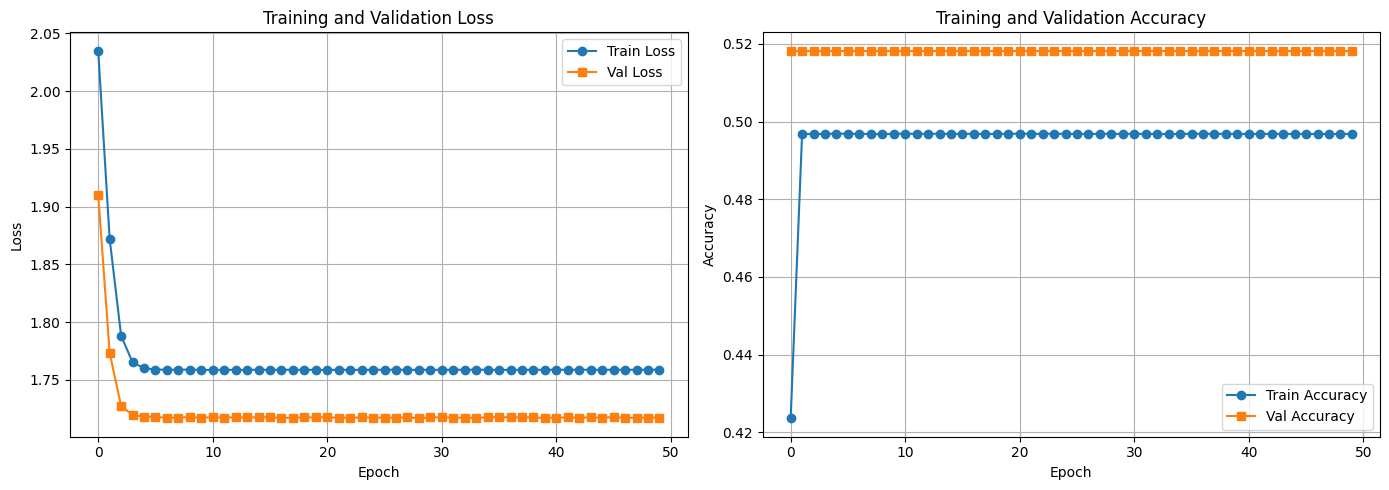


TRAINING SUMMARY
Total epochs: 50
Best validation loss: 1.7168
Final train loss: 1.7588
Final train accuracy: 0.4968
Final val loss: 1.7174
Final val accuracy: 0.5182

Model saved to: ../../checkpoints/final_classification_rnn/classification_rnn_model.pt


In [ ]:
# %% Save model
# Build cfg for the best run
best_cfg = {
    "device": device,
    "input_size": input_size,
    "num_classes": n_classes,
    "hidden_size": 128,
    "num_layers": 1,
    "dropout": 0.0,
    "lr":0.0001,
    "weight_decay": 0.0,
    "batch_size": 256,
    "epochs": 50,
    "grad_clip": 1.0,
}

# Make loaders & train a final model with best hyperparams
train_loader, val_loader = make_loaders(256)

model, train_losses, val_losses, train_accs, val_accs = _train_one_run(
    best_cfg, train_loader, val_loader
)

best_val_loss = min(val_losses)

# ==== Save model ====
MODEL_DIR = "../../checkpoints/classifier"
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, "classification_rnn_model.pt")
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to: {model_path}")

# ==== Plot training history ====
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ==== Training summary ====
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total epochs: {best_cfg['epochs']}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final train accuracy: {train_accs[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")
print(f"Final val accuracy: {val_accs[-1]:.4f}")
print(f"\nModel saved to: {model_path}")
print("="*60)

In [77]:
# Identify majority class in train and val
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_majority_cls = int(train_classes[np.argmax(train_counts)])

val_classes, val_counts = np.unique(y_val, return_counts=True)
val_majority_cls = int(val_classes[np.argmax(val_counts)])

print(f"Train majority class: {train_majority_cls} ({train_counts.max()} samples)")
print(f"Val majority class:   {val_majority_cls} ({val_counts.max()} samples)")

# Build constant logits that always predict the majority class
# We set a large positive logit for the majority class, zeros elsewhere
crit = nn.CrossEntropyLoss()

def constant_majority_loss_and_acc(X_t, y_t, majority_cls, num_classes):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    X_t = X_t.to(device)
    y_t = y_t.to(device)

    N = X_t.shape[0]
    # Create logits: shape (N, num_classes)
    logits = torch.zeros((N, num_classes), dtype=torch.float32, device=device)
    logits[:, majority_cls] = 10.0  # strong preference for the majority class

    # Loss
    loss = crit(logits, y_t).item()

    # Accuracy
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
    return loss, acc

num_classes = int(y_train.max() + 1)

train_loss_baseline, train_acc_baseline = constant_majority_loss_and_acc(
    X_train_t, y_train_t, train_majority_cls, num_classes
)
val_loss_baseline, val_acc_baseline = constant_majority_loss_and_acc(
    X_val_t, y_val_t, val_majority_cls, num_classes
)

print("\nMajority-class baseline:")
print(f"  Train -> Loss: {train_loss_baseline:.4f}, Acc: {train_acc_baseline:.4f}")
print(f"  Val   -> Loss: {val_loss_baseline:.4f}, Acc: {val_acc_baseline:.4f}")

Train majority class: 9 (143431 samples)
Val majority class:   9 (25641 samples)

Majority-class baseline:
  Train -> Loss: 5.0321, Acc: 0.4968
  Val   -> Loss: 4.8181, Acc: 0.5182


In [76]:
# Check how many points are in each cluster for train and val sets
unique, counts = np.unique(y_train, return_counts=True)
train_cluster_counts = dict(zip(unique, counts))
print("\nTraining set cluster distribution:")
for cluster, count in train_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")  

unique, counts = np.unique(y_val, return_counts=True)
val_cluster_counts = dict(zip(unique, counts))
print("\nValidation set cluster distribution:") 
for cluster, count in val_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")


Training set cluster distribution:
  Cluster 0: 8977 samples
  Cluster 1: 20736 samples
  Cluster 2: 15406 samples
  Cluster 3: 16671 samples
  Cluster 4: 31078 samples
  Cluster 5: 9066 samples
  Cluster 6: 17341 samples
  Cluster 7: 9338 samples
  Cluster 8: 16649 samples
  Cluster 9: 143431 samples

Validation set cluster distribution:
  Cluster 0: 2032 samples
  Cluster 1: 1581 samples
  Cluster 2: 4476 samples
  Cluster 3: 1836 samples
  Cluster 4: 5804 samples
  Cluster 5: 1576 samples
  Cluster 6: 3876 samples
  Cluster 7: 1190 samples
  Cluster 8: 1466 samples
  Cluster 9: 25641 samples


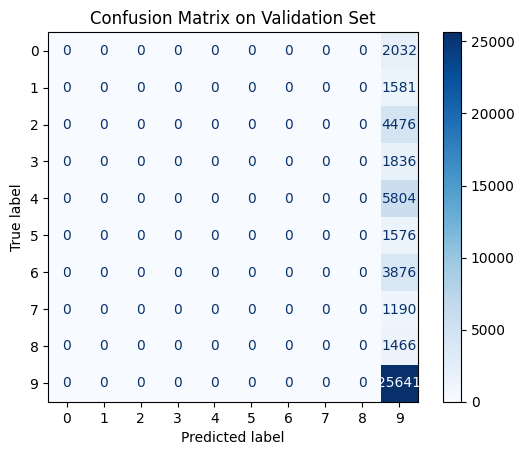

In [103]:
# Make confusion matrix on validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())   
cm = confusion_matrix(y_val, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()